# Label Transfer from HSCA Core to HSCA Extension using scArches

This section is adapted from the HLCA scArches tutorial:  
[HLCA scArches label transfer](https://docs.scarches.org/en/latest/hlca_map_classify.html)

We apply the same methodology to transfer cell type labels from the HSCA core to the HSCA extension datasets, utilizing the scArches framework.


In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import numpy as np
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import gdown

/opt/conda/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
#torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [ ]:
os.chdir("/data/projects/human_skin_cell_atlas/scripts")

In [5]:
dir_out_hsca_extended = "./scarches_output/HSCA/SCVI/HSCA_extended"

In [6]:
adata_full = sc.read(os.path.join(dir_out_hsca_extended, "extension_data_pooled_all_genes.h5ad"))
adata_full

AnnData object with n_obs × n_vars = 900321 × 48905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2'
    var: 'highly_variable'
    obsm: 'X_pca', 'X_pca_scvi', 'X_scvi_emb', 'X_u

In [ ]:
import re

for lvl in range(1, 6):
    col = f"celltype_lvl_{lvl}"
    inherited_col = f"inherited_{col}"

    # 1. Copy the original column including inherited annotations
    adata_full.obs[col] = adata_full.obs[inherited_col].copy()

    # 2. Remove inherited values (suffixes like "_1", "_2", etc.)
    adata_full.obs[col] = adata_full.obs[col].apply(
        lambda x: x if not isinstance(x, str) or not re.search(r"_\d+$", x) else None # hier wieder auf None nach debugging
    )

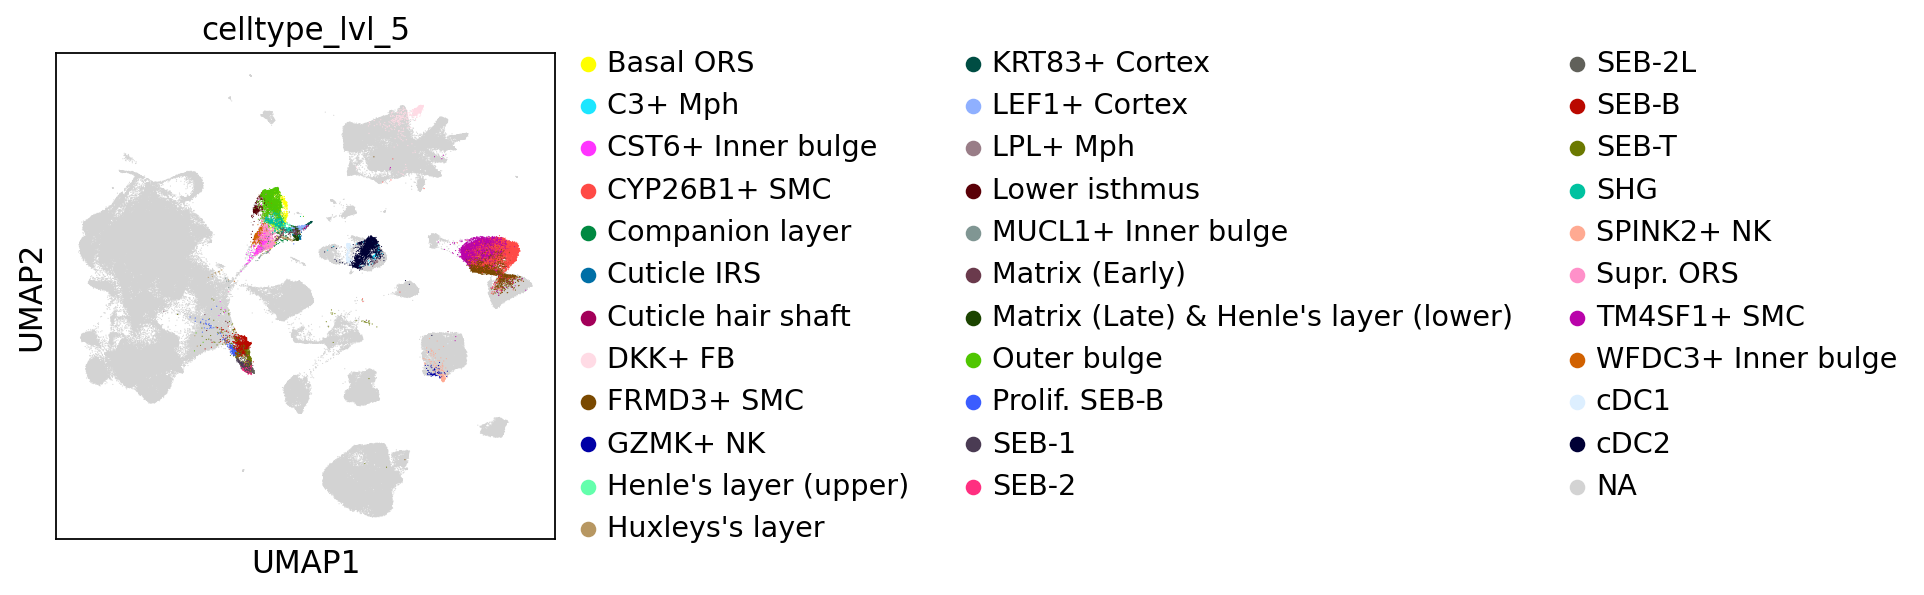

In [8]:
sc.pl.umap(adata_full,color='celltype_lvl_5',size=1)

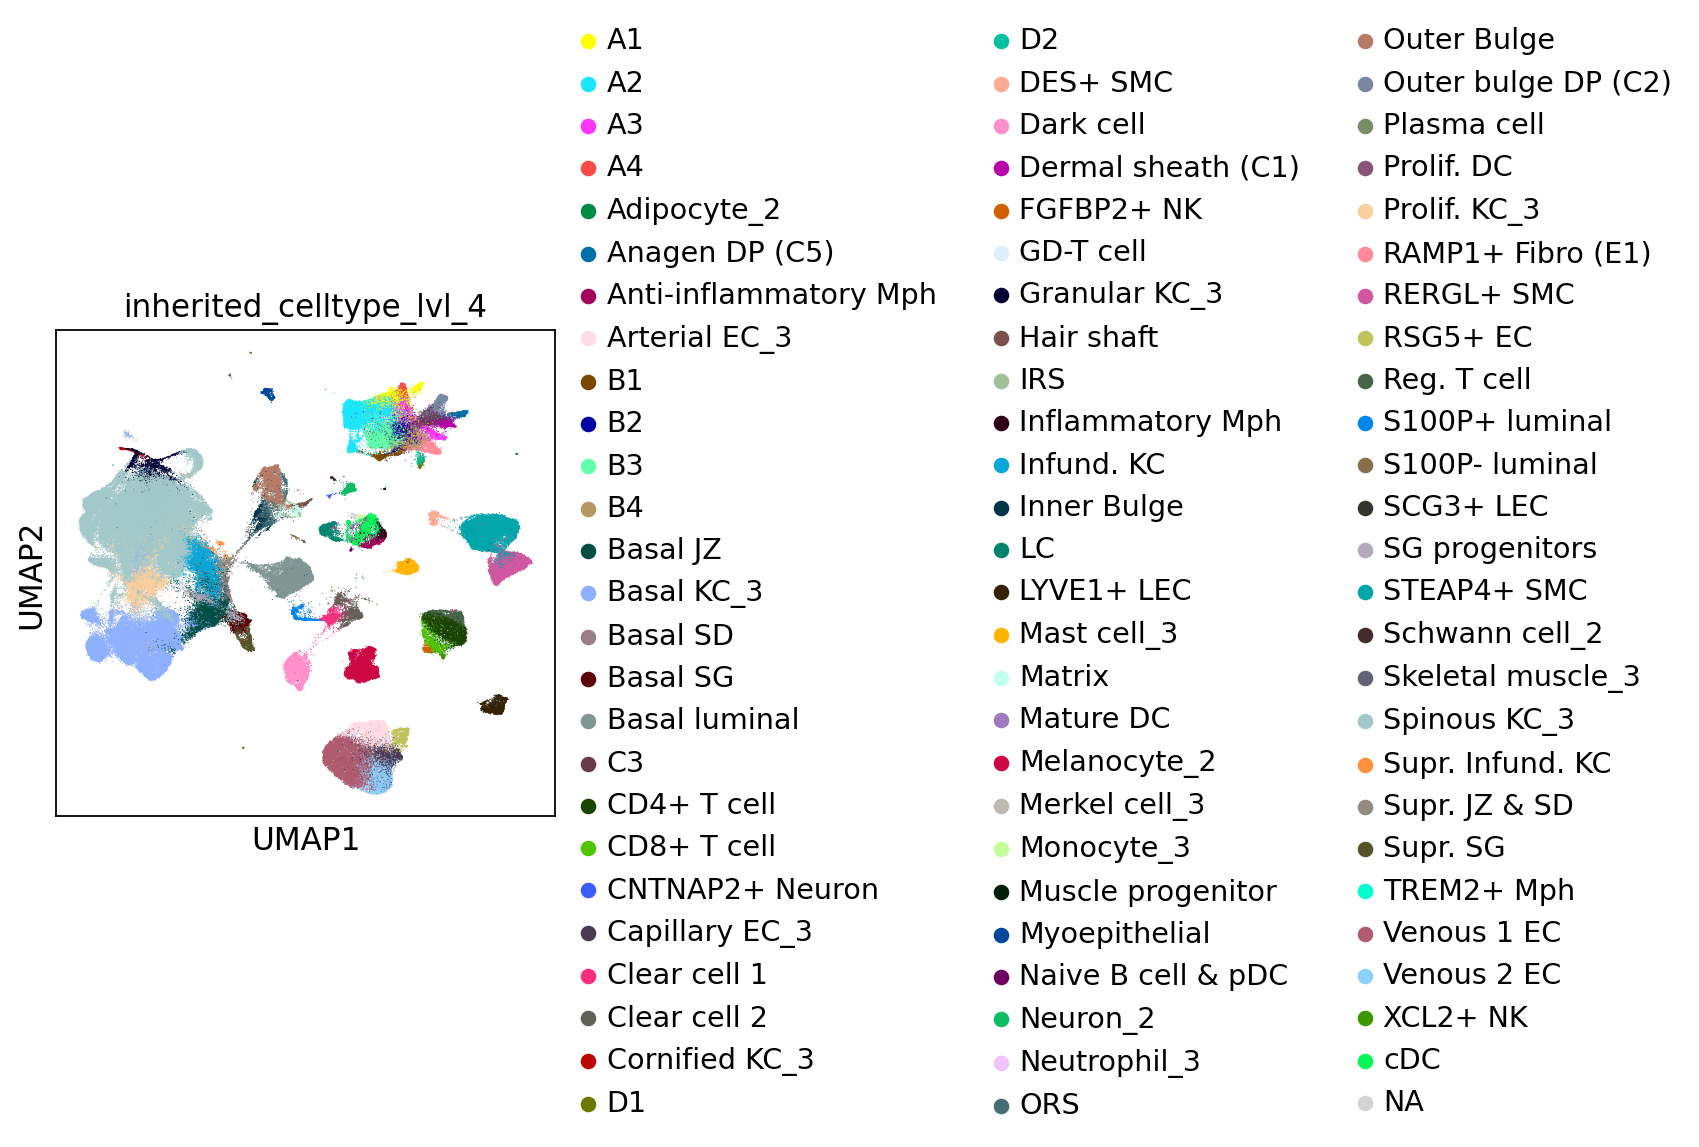

In [9]:
sc.pl.umap(adata_full,color='inherited_celltype_lvl_4',size=1)

In [10]:
full_latent = sc.AnnData(X=adata_full.obsm['X_scvi_emb'], obs=adata_full.obs)
full_latent

AnnData object with n_obs × n_vars = 900321 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltyp

In [11]:
full_latent.obs["Core"].value_counts()

No     606494
Yes    293827
Name: Core, dtype: int64

In [12]:
reference_embedding = full_latent[full_latent.obs["Core"] == "Yes"].copy()
target_embedding = full_latent[full_latent.obs["Core"] == "No"].copy()

In [13]:
reference_embedding

AnnData object with n_obs × n_vars = 293827 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltyp

In [14]:
target_embedding

AnnData object with n_obs × n_vars = 606494 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltyp

## Label Transfer from Reference to Query Datasets

**Note:** The following workflow and comments are directly adapted from the HLCA scArches tutorial 
([link](https://docs.scarches.org/en/latest/hlca_map_classify.html)). We include them here for clarity 
and to maintain the original explanations of each step.

All data and results shown in this notebook are specific to the Human Skin Cell Atlas (HSCA) and are original.


In [65]:
#Next, we use a knn classifier to transfer the lables from the reference to the query. As 
#the HLCA includes 5 levels of annotations (from coarse to fine), we will do the label transfer for every level of annotation.
#Note that some cell types don’t have annotations for higher levels, e.g. mast cells do not have level 4 or 5 annotations. 
#For those cell types, we will “propagate” to the higher levels, i.e. you will see “3_Mast cells” in level 4 and 5 annotations. 
#(Most cell types don’t have a level 5 annotation!) Therefore, all highest level annotations can be found under level 5

In [15]:
knn_transformer = sca.utils.knn.weighted_knn_trainer(
    train_adata=reference_embedding,
    train_adata_emb="X",  # location of our joint embedding
    n_neighbors=50,
)

Weighted KNN with n_neighbors = 50 ... 

In [16]:
reference_embedding.obs["inherited_celltype_lvl_5"].isnull().sum()


0

In [17]:
labels, uncert = sca.utils.knn.weighted_knn_transfer(
    query_adata=target_embedding,
    query_adata_emb="X",  # location of our embedding, query_adata.X in this case
    label_keys="inherited_celltype_lvl_",  # (start of) obs column name(s) for which to transfer labels
    knn_model=knn_transformer,
    ref_adata_obs=reference_embedding.obs,
)

finished!


In [ ]:
#With the commands above, we labeled every cell from the query (labels dataframe). Moreover, for each query cell we get
#an uncertainty score that tells you how confidently the label was assigned to the cell (uncert dataframe). 
#This uncertainty score is based on how consistent the reference labels were among the nearest neighbors of the query cell.
#High label transfer uncertainty can indicate a number of things:

#1. The cell lies in between two cellular phenotypes, e.g. in the case of a continuous transition of one cell type into another.

#2. The cell is of a cell type or subtype not present in the reference. For example, the HLCA does not include erythrocytes. 
#Erythrocytes in a query dataset will therefore likely be labeled with high uncertainty. Similarly, disease samples might 
#include disease-affected cell types that look different from the cells in a healthy reference. 
#These also likely have high label transfer uncertainty.

#3. The mapping did not successfully remove batch-effects in the query data from the embedding. Query cells do not mix with the reference 
#in the joint embedding, complicating confident label transfer. To distinguish low-uncertainty from high-uncertainty transferred labels, 
#we will set our high-uncertainty labels to “unknown” instead of giving them a cell type label. Cells with high uncertainty should be 
#looked into in downstream analysis.

In [ ]:
#We set the uncertainty threshold to 0.2, limiting the false positive rate to <0.5 (as per Sikkema et al., bioRxiv 2022). 
#If you are dealing with data that you expect to look very different from your reference (e.g. mouse data or cell line data), 
#you could consider setting this threshold higher.

In [18]:
uncertainty_threshold = 0.2

In [19]:
labels

,inherited_celltype_lvl_1,inherited_celltype_lvl_2,inherited_celltype_lvl_3,inherited_celltype_lvl_4,inherited_celltype_lvl_5
barcode,,,,,
PRJNA754272_SRR15440580_AAACCTGAGAATCTCC-1,Stroma,Fibroblast,Fibro A,A2,A2_4
PRJNA754272_SRR15440580_AAACCTGAGAGCAATT-1,Stroma,Fibroblast,Fibro B,B4,B4_4
PRJNA754272_SRR15440580_AAACCTGAGATATGCA-1,Stroma,Fibroblast,Fibro A,A1,A1_4
PRJNA754272_SRR15440580_AAACCTGAGATGGCGT-1,Neural lineage,Melanocyte,Melanocyte_2,Melanocyte_2,Melanocyte_2
PRJNA754272_SRR15440580_AAACCTGAGATGTGTA-1,Stroma,Fibroblast,Fibro A,A2,A2_4
...,...,...,...,...,...
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTGTCCGTG-1,Immune,Lymphoid,T cell,CD4+ T cell,CD4+ T cell_4
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTGTGTGGA-1,Immune,Lymphoid,T cell,CD4+ T cell,CD4+ T cell_4
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTTGCGGAA-1,Immune,Lymphoid,T cell,CD4+ T cell,CD4+ T cell_4


In [20]:
uncert

,inherited_celltype_lvl_1,inherited_celltype_lvl_2,inherited_celltype_lvl_3,inherited_celltype_lvl_4,inherited_celltype_lvl_5
barcode,,,,,
PRJNA754272_SRR15440580_AAACCTGAGAATCTCC-1,0.019993,0.019993,0.059987,0.520101,0.520101
PRJNA754272_SRR15440580_AAACCTGAGAGCAATT-1,0.0,0.0,0.0,0.0,0.0
PRJNA754272_SRR15440580_AAACCTGAGATATGCA-1,0.0,0.0,0.020009,0.200069,0.360042
PRJNA754272_SRR15440580_AAACCTGAGATGGCGT-1,0.0,0.0,0.0,0.0,0.0
PRJNA754272_SRR15440580_AAACCTGAGATGTGTA-1,0.0,0.0,0.0,0.259999,0.259999
...,...,...,...,...,...
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTGTCCGTG-1,0.0,0.0,0.0,0.059993,0.059993
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTGTGTGGA-1,0.0,0.0,0.0,0.040007,0.040007
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTTGCGGAA-1,0.0,0.0,0.0,0.079986,0.079986


In [21]:
labels.rename(
    columns={
        f"inherited_celltype_lvl_{lev}": f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered"
        for lev in range(1, 6)
    },
    inplace=True,
)
uncert.rename(
    columns={
        f"inherited_celltype_lvl_{lev}": f"inherited_celltype_lvl_{lev}_transfer_uncert"
        for lev in range(1, 6)
    },
    inplace=True,
)

In [22]:
labels.to_csv("./celltype_labels.csv")
uncert.to_csv("./celltype_uncert.csv")

In [23]:
import pandas as pd

labels = pd.read_csv("celltype_labels.csv", index_col=0)
uncert = pd.read_csv("celltype_uncert.csv", index_col=0)


In [24]:
labels

,inherited_celltype_lvl_1_transferred_label_unfiltered,inherited_celltype_lvl_2_transferred_label_unfiltered,inherited_celltype_lvl_3_transferred_label_unfiltered,inherited_celltype_lvl_4_transferred_label_unfiltered,inherited_celltype_lvl_5_transferred_label_unfiltered
barcode,,,,,
PRJNA754272_SRR15440580_AAACCTGAGAATCTCC-1,Stroma,Fibroblast,Fibro A,A2,A2_4
PRJNA754272_SRR15440580_AAACCTGAGAGCAATT-1,Stroma,Fibroblast,Fibro B,B4,B4_4
PRJNA754272_SRR15440580_AAACCTGAGATATGCA-1,Stroma,Fibroblast,Fibro A,A1,A1_4
PRJNA754272_SRR15440580_AAACCTGAGATGGCGT-1,Neural lineage,Melanocyte,Melanocyte_2,Melanocyte_2,Melanocyte_2
PRJNA754272_SRR15440580_AAACCTGAGATGTGTA-1,Stroma,Fibroblast,Fibro A,A2,A2_4
...,...,...,...,...,...
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTGTCCGTG-1,Immune,Lymphoid,T cell,CD4+ T cell,CD4+ T cell_4
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTGTGTGGA-1,Immune,Lymphoid,T cell,CD4+ T cell,CD4+ T cell_4
EMTAB13084_1_WS_SKN_KCL10525741_TTTGTTGGTTGCGGAA-1,Immune,Lymphoid,T cell,CD4+ T cell,CD4+ T cell_4


In [111]:
labels

,inherited_celltype_lvl_1_transferred_label_unfiltered,inherited_celltype_lvl_2_transferred_label_unfiltered,inherited_celltype_lvl_3_transferred_label_unfiltered,inherited_celltype_lvl_4_transferred_label_unfiltered,inherited_celltype_lvl_5_transferred_label_unfiltered
barcode,,,,,
EMTAB8142_s1_Derm_Fibro_AAACCTGAGACTCGGA,Stroma,Fibroblast,Fibro B,B2,B2_4
EMTAB8142_s1_Derm_Fibro_AAACCTGCAAAGGCGT,Stroma,Fibroblast,Fibro A,A1,A1_4
EMTAB8142_s1_Derm_Fibro_AAACGGGTCCAGTAGT,Stroma,Fibroblast,Fibro A,A2,A2_4
EMTAB8142_s1_Derm_Fibro_AAAGATGAGAGGACGG,Stroma,Fibroblast,Fibro B,B2,B2_4
EMTAB8142_s1_Derm_Fibro_AAAGATGGTTCCGGCA,Stroma,Fibroblast,Fibro A,A2,A2_4
...,...,...,...,...,...
EGAS00001002927_2_EGAF00002191955_TTTGTCATCGTATCAG-1,Cutaneous Epithelial,Interfollicular Epidermis,Basal KC,Basal KC_3,Basal KC_3
EGAS00001002927_2_EGAF00002191955_TTTGTCATCTACTCAT-1,Neural lineage,Melanocyte,Melanocyte_2,Melanocyte_2,Melanocyte_2
EGAS00001002927_2_EGAF00002191955_TTTGTCATCTCTGAGA-1,Cutaneous Epithelial,Interfollicular Epidermis,Spinous KC,Spinous KC_3,Spinous KC_3


In [25]:
full_latent.obs = full_latent.obs.join(labels)
full_latent.obs = full_latent.obs.join(uncert)

In [26]:
full_latent

AnnData object with n_obs × n_vars = 900321 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltyp

### Next, we create a filtered label column for each cell type, assigning labels with a transfer uncertainty greater than 0.2 as 'Unknown'.

In [27]:
for lev in range(1, 6):
    full_latent.obs[f"inherited_celltype_lvl_{lev}_transferred_label"] = full_latent.obs[
        f"inherited_celltype_lvl_{lev}_transferred_label_unfiltered"
    ].mask(
        full_latent.obs[f"inherited_celltype_lvl_{lev}_transfer_uncert"] > uncertainty_threshold,
        "Unknown",
    )

In [28]:
full_latent.obs.inherited_celltype_lvl_1_transferred_label.value_counts()

Stroma                  218269
Immune                  148363
Cutaneous Epithelial    141810
Endothelial              47291
Unknown                  28456
Neural lineage           22305
Name: inherited_celltype_lvl_1_transferred_label, dtype: int64

In [29]:
print(
    f"Percentage of unknown per level, with uncertainty_threshold={uncertainty_threshold}:"
)
for level in range(1, 6):
    print(
        f"Level {level}: {np.round(sum(full_latent.obs[f'inherited_celltype_lvl_{level}_transferred_label'] =='Unknown')/target_embedding.n_obs*100,2)}%"
    )

Percentage of unknown per level, with uncertainty_threshold=0.2:
Level 1: 4.69%
Level 2: 8.11%
Level 3: 22.57%
Level 4: 41.87%
Level 5: 45.3%


In [30]:
adata_full

AnnData object with n_obs × n_vars = 900321 × 48905
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'cell

In [35]:
full_latent

AnnData object with n_obs × n_vars = 900321 × 10
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'subject_ID', 'age_years', 'age_range', 'sex', 'ethnicity', 'anatomical_region_level1', 'anatomical_region_level2', 'anatomical_region_level3', 'sequencing_platform', 'reference_genome_compact', 'cell_ranger_version_compact', 'single_cell_platform', 'tissue_sampling_type', 'Accession_source', 'Dataset', 'Condition', 'Core', 'percent_mito', 'soup_group', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.class', 'genes', 'RNA_snn_res.1.2', 'seurat_clusters', 'orig_celltype_lvl_3', 'RNA_snn_res.0.8', 'RNA_snn_res.1.6', 'fresh_or_frozen', 'RNA_snn_res.1.8', 'RNA_snn_res.1.5', 'seurat_clusters_full', 'RNA_snn_res.2', 'inherited_celltype_lvl_1', 'inherited_celltype_lvl_2', 'inherited_celltype_lvl_3', 'inherited_celltype_lvl_4', 'inherited_celltype_lvl_5', 'barcode', 'UMAP_1', 'UMAP_2', 'celltype_lvl_1', 'celltype_lvl_2', 'celltype_lvl_3', 'celltype_lvl_4', 'celltyp